# Java Plagiarism Detector

Import Lexer analyzer and source code to analyze

In [4]:
from java_lexer import Lexer
from source_codes import SOURCE_CODE2, SOURCE_CODE1, SOURCE_CODE3, SOURCE_CODE4

Call Lexer class and obtain all tokens from source code

In [5]:

import pandas as pd

# Read CSV file
data = pd.read_csv('downsampled_dataset_separado.csv')

# Extract columns from CSV
column_names = ['code1', 'code2', 'plagium']
columns_data = data[column_names]

# Create a new DataFrame with the extracted column
downsampled_dataset = pd.DataFrame(columns_data)

downsampled_dataset

,code1,code2,plagium
0,IMPORT import java.io.BufferedReader; IMPORT i...,IMPORT import java.io.IOException; IMPORT impo...,0
1,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,0
2,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,0
3,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,0
4,IMPORT import java.io.BufferedReader; IMPORT i...,IDENTIFIER KEYWORD static IDENTIFIER PUNCTUA...,0
...,...,...,...
491,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,1
492,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,IMPORT import java.io.BufferedReader; IMPORT i...,1
493,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,1
494,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,IMPORT import java.io.BufferedReader; IMPORT i...,1


In [6]:
print("non plagium samples",(downsampled_dataset['plagium'] == 0).sum())

print("plagium samples", (downsampled_dataset['plagium'] == 1).sum())


non plagium samples 248
plagium samples 248


In [7]:
from sklearn.model_selection import train_test_split
proceesed_data_df = pd.DataFrame(downsampled_dataset)


train_df, test_df = train_test_split(
        proceesed_data_df,
        test_size=0.2,
        random_state=202
)

In [8]:
train_df

,code1,code2,plagium
244,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,0
399,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,1
69,IMPORT import java.io.BufferedReader; IMPORT i...,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,0
416,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,1
219,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,0
...,...,...,...
296,IMPORT import java.util.Scanner; KEYWORD publi...,IMPORT import java.util.Scanner; KEYWORD publi...,1
460,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,1
60,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,0
151,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,IDENTIFIER IDENTIFIER PUNCTUATION . IDENTIFI...,0


In [9]:
print("non plagium samples",(train_df['plagium'] == 0).sum())

print("plagium samples", (train_df['plagium'] == 1).sum())


non plagium samples 196
plagium samples 200


In [10]:
X_train = train_df[["code1","code2"]]
X_test = test_df[["code1","code2"]]
y_train = train_df[["plagium"]]
y_test = test_df[["plagium"]]

print(len(X_train))
print(len(y_train))

396
396


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from transformers import TFGPT2ForSequenceClassification, GPT2Tokenizer
import numpy as np

# Define the maximum sequence length
max_sequence_length = 1000

# Create the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Convert the text data to sequences
X_train_flattened = X_train["code1"] + X_train["code2"]
tokenizer.pad_token = tokenizer.eos_token
X_train_sequences = tokenizer.batch_encode_plus(X_train_flattened,
                                                padding=True,
                                                truncation=True,
                                                max_length=max_sequence_length,
                                                return_tensors='tf')

X_test_flattened = X_test["code1"] + X_test["code2"]
X_test_sequences = tokenizer.batch_encode_plus(X_test_flattened,
                                               padding=True,
                                               truncation=True,
                                               max_length=max_sequence_length,
                                               return_tensors='tf')

# Convert y_train and y_test to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Define the inputs
input1 = Input(shape=(max_sequence_length,), dtype=tf.int32)
input2 = Input(shape=(max_sequence_length,), dtype=tf.int32)

# Load the pre-trained GPT-2 model
gpt2_model = TFGPT2ForSequenceClassification.from_pretrained('gpt2')

# Get the GPT-2 model outputs
outputs = gpt2_model(input1)['logits']

# Apply Dense layer to input sequences
dense_output1 = Dense(64)(input1)

dense_output1 = Dense(64)(dense_output1)

# Apply Dense layer to input sequences
dense_output2 = Dense(64)(input2)

dense_output2 = Dense(64)(dense_output2)

# Merge the Dense outputs
merged_output = Concatenate()([dense_output1, dense_output2])


# Add a dense layer for classification
dense_output = Dense(1, activation='sigmoid')(merged_output)

# Define the model
model = Model(inputs=[input1, input2], outputs=dense_output)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

All model checkpoint layers were used when initializing TFGPT2ForSequenceClassification.

Some layers of TFGPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           64064       ['input_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 64)           64064       ['input_2[0][0]']                
                                                                                              

In [72]:
# Train the model
model.fit(
    x=[X_train_sequences['input_ids'], X_train_sequences['attention_mask']],
    y=y_train,
    batch_size=32,
    epochs=40,
    validation_data=(
        [X_test_sequences['input_ids'], X_test_sequences['attention_mask']],
        y_test
    )
)

Epoch 1/40
13/13 [==============================] - 2s 32ms/step - loss: 8233.1504 - accuracy: 0.5152 - val_loss: 6543.3687 - val_accuracy: 0.5200
Epoch 2/40
13/13 [==============================] - 0s 9ms/step - loss: 2516.5425 - accuracy: 0.6818 - val_loss: 3091.7756 - val_accuracy: 0.6000
Epoch 3/40
13/13 [==============================] - 0s 8ms/step - loss: 1542.6753 - accuracy: 0.7601 - val_loss: 2805.0967 - val_accuracy: 0.6400
Epoch 4/40
13/13 [==============================] - 0s 8ms/step - loss: 578.7358 - accuracy: 0.8561 - val_loss: 2355.4272 - val_accuracy: 0.6800
Epoch 5/40
13/13 [==============================] - 0s 8ms/step - loss: 308.5219 - accuracy: 0.8889 - val_loss: 2099.9746 - val_accuracy: 0.6600
Epoch 6/40
13/13 [==============================] - 0s 6ms/step - loss: 299.3088 - accuracy: 0.9015 - val_loss: 2070.0771 - val_accuracy: 0.6800
Epoch 7/40
13/13 [==============================] - 0s 6ms/step - loss: 213.8318 - accuracy: 0.9167 - val_loss: 1934.6497 - va

In [13]:
model.load_weights('./GPT_model/balanced_model')

In [79]:
model.save_weights('./GPT_model/balanced_model')

In [14]:
loss, accuracy = model.evaluate(
    x=[X_test_sequences['input_ids'], X_test_sequences['attention_mask']],
    y=y_test,
    batch_size=32
)

# Print the evaluation results
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

4/4 [==============================] - 0s 4ms/step - loss: 1599.0953 - accuracy: 0.7600
Test Loss: 1599.0953369140625
Test Accuracy: 0.7599999904632568


4/4 [==============================] - 0s 2ms/step


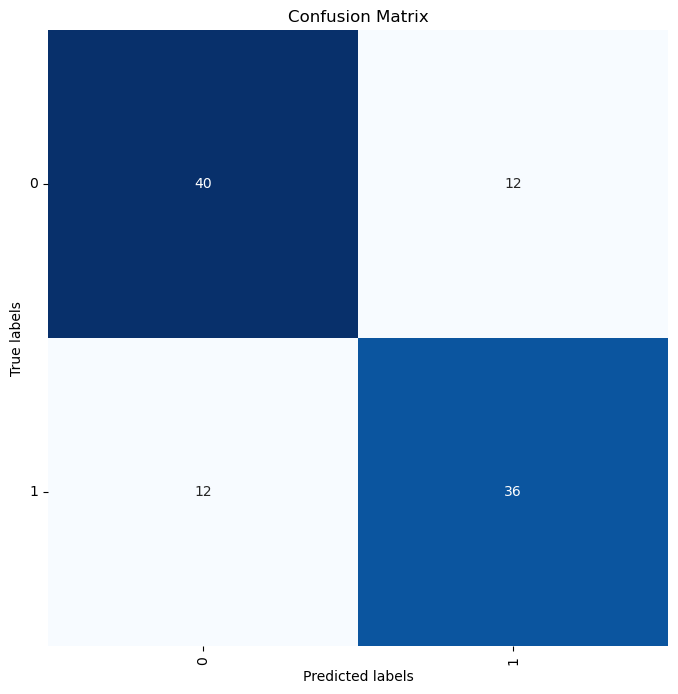

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Model predictions
predictions = model.predict([X_test_sequences['input_ids'], X_test_sequences['attention_mask']])
predicted_labels = (predictions > 0.5).astype(int)

# Create confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# Get class labels
class_labels = ["0", "1"]

# Create figure
plt.figure(figsize=(8, 8))
ax = plt.gca()

# Create heatmap with seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)

# Add labels to axis
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.set_xticklabels(class_labels, rotation=90)
ax.set_yticklabels(class_labels, rotation=0)

# Show confusion matrix
plt.show()
